# Visualization of Relations Based on JIRA Issues


## Part #1: Data reading & cleanup

### Loading of data manipulation libraries

In [1]:
import pandas as pd
import re

### Datafile processing

The result of JIRA issues export into Excel is an HTML file. This file can be read using read_html function from pandas library.

In [2]:
df_list = pd.read_html('example/exported-issues-search-result.xls', r'Issue')
issues_df = df_list[0]
issues_df.columns = issues_df.columns.map(str.strip)

for col in ('Developers', 'Reviewers', 'QAs'):
    issues_df[col] = issues_df[col].str.split(',')

issues_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 9 columns):
Issue Type       201 non-null object
Key              201 non-null object
Priority         201 non-null object
Status           201 non-null object
On Production    200 non-null object
Creator          201 non-null object
Developers       200 non-null object
Reviewers        147 non-null object
QAs              152 non-null object
dtypes: object(9)
memory usage: 14.2+ KB


### Exploration of the loaded dataframe

In [3]:
relations_df = issues_df[ issues_df['Developers'].notnull() | issues_df['Reviewers'].notnull() | issues_df['QAs'].notnull() ]
len(relations_df)

200

In [4]:
mandatory_columns = ['Key', 'Creator', 'Developers', 'Reviewers', 'QAs']

relations_df[mandatory_columns]

,Key,Creator,Developers,Reviewers,QAs
0,BACK-1246,Aida,"[Enjolras, Gaspard Caderousse (Leave), Jean ...",NaN,NaN
1,BACK-75,Javert,[Javert],[Jean Valjean],"[Aida, QA Team]"
2,LAB-59,Jean Valjean,[Jean Valjean],[Javert],"[Aida, Feuilly]"
3,BACK-4407,Jean Valjean,"[Javert, Jean Valjean]",NaN,NaN
4,LAB-153,Jean Valjean,[Jean Valjean],NaN,NaN
5,BACK-05,Aida,[Jean Valjean],NaN,NaN
6,BACK-9524,Jean Valjean,[Jean Valjean],[Javert],"[Aida, Patron-Minette]"
7,BACK-9484,Louis Dantès,[Champmathieu],"[Lesgle, Champmathieu, Jean Valjean]","[Aida, Mademoiselle Gillenormand, Champmathieu]"
8,BACK-9986,Feuilly,[Jean Valjean],NaN,NaN
9,BACK-9708,Madame Magloire,[Marius Pontmercy],[Jean Valjean],"[Aida, Bishop Myriel, QA Team, Marius Pontm..."


## Part #2: the relations graph building

### Edges list generation

In [5]:
edges_list = []

users_to_ignore = ('Aida', 'QA Team',)

def get_normalized_user_name(name):
    result = str(name).strip()
    result = re.sub(r'\s*\(.+?\)\s*', '', result)
    return result

df_creator_developers = relations_df.loc[relations_df['Developers'].notnull(), ['Creator', 'Developers', 'Key']]
for index, row in df_creator_developers.iterrows():
    issue_key = row['Key']
    creator = get_normalized_user_name(row['Creator'])
    if creator in users_to_ignore:
        continue
    
    dev_names_list = [get_normalized_user_name(x) for x in row['Developers']]
    for dev_name in dev_names_list:
        if dev_name in users_to_ignore:
            continue
        
        edge = (creator, dev_name, issue_key)
        edges_list.append(edge)


df_developers_reviewers = relations_df.loc[
    relations_df['Developers'].notnull() & relations_df['Reviewers'].notnull(),
    ['Developers', 'Reviewers', 'Key']
]
for index, row in df_developers_reviewers.iterrows():
    issue_key = row['Key']

    dev_names_list = [get_normalized_user_name(x) for x in row['Developers']]
    reviewer_names_list = [get_normalized_user_name(x) for x in row['Reviewers']]
    for dev_name in dev_names_list:
        if dev_name in users_to_ignore:
            continue
        
        for review_name in reviewer_names_list:
            if (review_name in users_to_ignore) or (dev_name == review_name):
                continue
        
        edge = (dev_name, review_name, issue_key)
        edges_list.append(edge)

df_developers_reviewers = relations_df.loc[
    relations_df['Developers'].notnull() & relations_df['QAs'].notnull(),
    ['Developers', 'QAs', 'Key']
]
for index, row in df_developers_reviewers.iterrows():
    issue_key = row['Key']
    
    dev_names_list = [get_normalized_user_name(x) for x in row['Developers']]
    qa_names_list = [get_normalized_user_name(x) for x in row['QAs']]
    for dev_name in dev_names_list:
        if dev_name in users_to_ignore:
            continue
        
        for qa_name in qa_names_list:
            if (qa_name in users_to_ignore) or (dev_name == qa_name):
                continue
        
        edge = (dev_name, qa_name, issue_key)
        edges_list.append(edge)

edges_list

[('Javert', 'Javert', 'BACK-75'),
 ('Jean Valjean', 'Jean Valjean', 'LAB-59'),
 ('Jean Valjean', 'Javert', 'BACK-4407'),
 ('Jean Valjean', 'Jean Valjean', 'BACK-4407'),
 ('Jean Valjean', 'Jean Valjean', 'LAB-153'),
 ('Jean Valjean', 'Jean Valjean', 'BACK-9524'),
 ('Louis Dantès', 'Champmathieu', 'BACK-9484'),
 ('Feuilly', 'Jean Valjean', 'BACK-9986'),
 ('Madame Magloire', 'Marius Pontmercy', 'BACK-9708'),
 ('Lord Wilmore', 'Joly', 'BACK-8625'),
 ('Lord Wilmore', 'Cosette', 'BACK-8625'),
 ('Patron-Minette', 'Jean Valjean', 'BACK-9813'),
 ('Barrois', 'Éponine', 'BACK-9732'),
 ('Luigi Vampa', 'Javert', 'BACK-9564'),
 ('Jean Valjean', 'Jean Valjean', 'BACK-8850'),
 ('Jean Valjean', 'Albert de Morcerf', 'BI-1234'),
 ('Giovanni Bertuccio', 'Jean Valjean', 'BACK-9747'),
 ('Maximilien Morrel', 'Jean Valjean', 'BACK-9327'),
 ('Countess Teresa Guiccioli', 'Jean Valjean', 'BACK-9719'),
 ('Colonel Georges Pontmercy', 'Jean Valjean', 'BACK-9663'),
 ('Enjolras', 'Cosette', 'BACK-8681'),
 ('Jean Valj

### Edges exploration

In [6]:
user_to_check = 'Jean Valjean'
[x for x in edges_list if (user_to_check in x) and ('Javert' in x)]

[('Jean Valjean', 'Javert', 'BACK-4407'),
 ('Jean Valjean', 'Javert', 'BACK-7413'),
 ('Javert', 'Jean Valjean', 'BACK-75'),
 ('Jean Valjean', 'Javert', 'LAB-59'),
 ('Jean Valjean', 'Javert', 'BACK-9524'),
 ('Javert', 'Jean Valjean', 'BACK-9564'),
 ('Javert', 'Jean Valjean', 'BACK-9172'),
 ('Javert', 'Jean Valjean', 'BACK-9264'),
 ('Javert', 'Jean Valjean', 'BACK-9302'),
 ('Javert', 'Jean Valjean', 'BACK-9185'),
 ('Javert', 'Jean Valjean', 'BACK-9115'),
 ('Javert', 'Jean Valjean', 'BACK-8596'),
 ('Javert', 'Jean Valjean', 'BACK-7413'),
 ('Jean Valjean', 'Javert', 'BACK-8600'),
 ('Jean Valjean', 'Javert', 'BACK-8672'),
 ('Javert', 'Jean Valjean', 'BACK-7644'),
 ('Jean Valjean', 'Javert', 'BACK-7362'),
 ('Javert', 'Jean Valjean', 'BACK-7472'),
 ('Javert', 'Jean Valjean', 'BACK-7444'),
 ('Javert', 'Jean Valjean', 'BACK-6959'),
 ('Javert', 'Jean Valjean', 'BACK-6685'),
 ('Javert', 'Jean Valjean', 'WEB-1468'),
 ('Javert', 'Jean Valjean', 'BACK-6706'),
 ('Javert', 'Jean Valjean', 'BACK-5461')

### Graph building and reducing

It's hard to make a readable visualization of a graph with big number of edges, so we can reduce its size removing of a fraction of the input nodes and edges.

In [7]:
import networkx as nx

# Initial graph building
g = nx.Graph()
for user1, user2, issue_key in edges_list:
    if g.has_edge(user1, user2):
        g[user1][user2]['weight'] += 1
    else:
        g.add_edge(user1, user2, weight=1)
    
# Reducing of the graph dimentions...
g_reduced = g.copy()

# Step #1: removing of "eventual" edges
min_edge_weight_to_keep = 3
for node1, node2, edge_data in g_reduced.edges(data=True):
    if (edge_data['weight'] < min_edge_weight_to_keep) or (node1 == node2):
        g_reduced.remove_edge(node1, node2)

# Step #2: removing of dead nodes (nodes wihtout without any edges)
g_reduced_degree = nx.degree(g_reduced)
nodes_to_remove = [ node for node, node_degree in g_reduced_degree.items() if not node_degree ]
g_reduced.remove_nodes_from(nodes_to_remove)

# The result dimensions
(
    {'input_nodes': len(g.nodes()), 'input_edges': len(g.edges())},
    {'reduced_nodes': len(g_reduced.nodes()), 'reduced_edges': len(g_reduced.edges())},
)

({'input_edges': 200, 'input_nodes': 79},
 {'reduced_edges': 35, 'reduced_nodes': 28})

### Reduced graph exploration

In [8]:
out_df = nx.to_edgelist(g_reduced)
sorted(out_df, key=lambda x: x[2]['weight'], reverse=True)

[('Marius Pontmercy', 'Jean Valjean', {'weight': 43}),
 ('Javert', 'Jean Valjean', {'weight': 28}),
 ('Fantine', 'Jean Valjean', {'weight': 16}),
 ('Cosette', 'Jean Valjean', {'weight': 16}),
 ('Éponine', 'Jean Valjean', {'weight': 11}),
 ('Maximilien Morrel', 'Jean Valjean', {'weight': 9}),
 ('Colonel Georges Pontmercy', 'Jean Valjean', {'weight': 8}),
 ('Enjolras', 'Jean Valjean', {'weight': 8}),
 ('QA Team', 'Jean Valjean', {'weight': 6}),
 ('QA Team', 'Cosette', {'weight': 6}),
 ('Feuilly', 'Jean Valjean', {'weight': 6}),
 ('Monsieur Thénardier', 'Jean Valjean', {'weight': 6}),
 ('QA Team', 'Javert', {'weight': 5}),
 ('Grantaire', 'Jean Valjean', {'weight': 5}),
 ('Bahorel', 'Jean Valjean', {'weight': 5}),
 ('Javert', 'Courfeyrac', {'weight': 5}),
 ('Mademoiselle Gillenormand', 'Jean Valjean', {'weight': 5}),
 ('Marius Pontmercy', 'Feuilly', {'weight': 4}),
 ('Brevet', 'Jean Valjean', {'weight': 4}),
 ('Petit Gervais', 'Jean Valjean', {'weight': 4}),
 ('Gavroche', 'Jean Valjean', {

In [9]:
sorted([x for x in nx.degree(g).items()], key=lambda x: x[1], reverse=True)

[('Jean Valjean', 61),
 ('Javert', 30),
 ('Fantine', 22),
 ('Cosette', 18),
 ('Marius Pontmercy', 17),
 ('Éponine', 14),
 ('QA Team', 12),
 ('Enjolras', 12),
 ('Monsieur Thénardier', 12),
 ('Madame Thénardier', 11),
 ('Grantaire', 10),
 ('Gavroche', 8),
 ('Bishop Myriel', 8),
 ('Bahorel', 7),
 ('Combeferre', 7),
 ('Feuilly', 6),
 ('Courfeyrac', 6),
 ('Magnon', 5),
 ('Jean Prouvaire', 5),
 ('Azelma', 5),
 ('Joly', 5),
 ('Lesgle', 5),
 ('Madame Bougon', 4),
 ('Colonel Georges Pontmercy', 4),
 ('Cochepaille', 4),
 ('Champmathieu', 4),
 ('Brevet', 4),
 ('Chenildieu', 4),
 ('Bamatabois', 4),
 ('Brujon', 4),
 ('Monsieur Gillenormand', 3),
 ('Mother Innocente', 3),
 ('Fauchelevent', 3),
 ('Sister Simplice', 3),
 ('Petit Gervais', 3),
 ('Mabeuf', 3),
 ('Patron-Minette', 3),
 ('Madame Magloire', 3),
 ('Mademoiselle Gillenormand', 3),
 ('Albert de Morcerf', 2),
 ('Haydée', 2),
 ('Giovanni Bertuccio', 2),
 ('Luigi Vampa', 2),
 ('Mercédès Mondego', 2),
 ('Peppino', 2),
 ('Abbé Faria', 2),
 ('Monsi

## Part #3: Visualizing

### Loading of image building libraries

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

### Visualization building

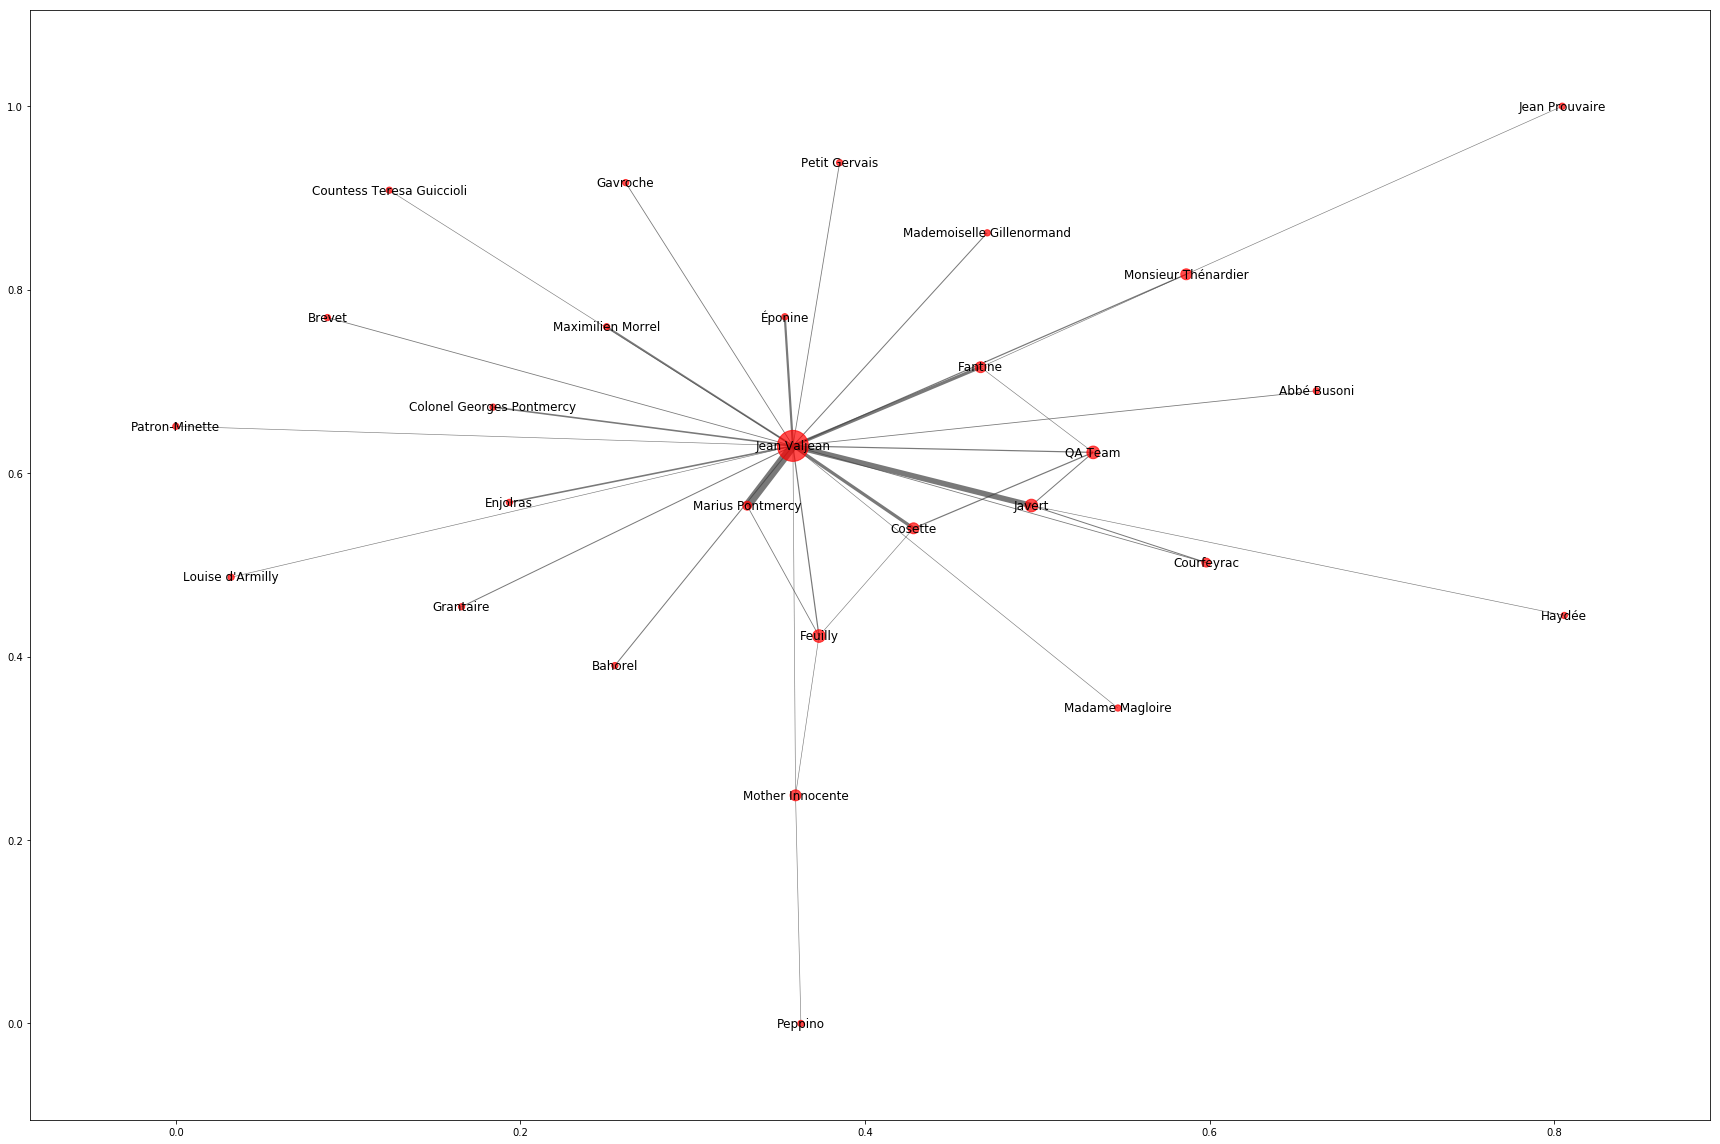

In [11]:
plt.figure(figsize=(24, 16))

node_size = [40 * g_reduced_degree[v] for v in g_reduced]
edge_width = [0.2 * g_reduced[u][v]['weight'] for u,v in g_reduced.edges()]

# More layouts:
# https://networkx.github.io/documentation/networkx-1.10/reference/drawing.html#module-networkx.drawing.layout

nx.draw_networkx(
    g_reduced,
    pos=nx.spring_layout(g_reduced),
    node_size=node_size, 
    alpha=0.7,
    with_labels=True, 
    width=edge_width,
    edge_color='.25'
)

#plt.axis('off')
plt.tight_layout()
plt.show()